In [1]:
#Necessary Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import html5lib
import unittest
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import xgboost
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
pd.options.display.float_format ='{:.2f}'.format


In [2]:
## Configure and Collect Data
## Retrieve Data from given url
# Return data in a pandas DataFrame
def configure(url):
    
    
    ## Create header to access Webpage
    hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
    
    try:
        #Retrieve Webpage Table
        data = requests.get(url, headers=hdr)
        soup = BeautifulSoup(data.text, 'html.parser')
        table = soup.find_all('table')
        df = pd.read_html(str(table))[0]
        print('Successfully retrieved table from ' + url)
        return df
    except Exception as error:
        #Throw Error
        print('Unsuccesful Retrieval: Error trying to retrieve table from given Url', error)
        


In [3]:
## Removes unnecessary characters from Player names and Fixes abnormal Column names
def cleanPlayerName(df):
    try:
        for i in df['Player']:
            player = i
            #print(player)

            L = False
            R = 0

            while R < len(player):

                if player[R] == ' ' and L == False:
                    L = True
                elif player[R] == '.' and L == True:
                    df['Player'] = df['Player'].replace(player, player[:R])
                    break
                R += 1
        df['Player'] = df['Player'].str[:-1]
        
        #df.index = df['Player']
    except:
        print('Error trying to clean player names')

#Removes unnecessary characters from Team names
def cleanTeamName(df):
    try:
        for i in df['Team']:
            team = i

            L = False
            R =0

            while R < len(team):
                if (team[R].isupper() or team[R].isdigit()) and L == False:
                    L = True    
                elif team[R].isupper() and L == True:
                    df['Team']= df['Team'].replace(team, team[:R])
                    break    
                elif team[R] == " ":
                    L = False
                R += 1  
    except:
        print('Error trying to clean team names')

In [4]:
def cleanPlayerData(df):
    df['Lg'] = df['Lg'].str.replace('[A-Za-z]', '', regex=True)
    df['Lg']=df['Lg'].astype('float64')
def cleanTeamData(df):
    df.columns = df.columns.str.replace(u'\xa0', '_')


In [5]:
def initialFilterDF(dfPass,dfRush,dfReceive,dfOffense,dfDefense,dfPlays):
    filteredPass = dfPass[['Player', 'Team', 'Gms', 'Att','Cmp', 'Yds', 'TD', 'Int', 'Sack', 'Loss']]
    filteredRush = dfRush[['Player', 'Team', 'Gms', 'Att', 'Yds', 'TD', 'FD']]
    filteredReceive = dfReceive[['Player', 'Team', 'Gms', 'Rec', 'Yds', 'TD', 'FD', 'Tar', 'YAC']]
    filteredOffense = dfOffense[['Team','Gms', 'Tot_Pts', 'RushYds', 'PassYds', 'TotYds']]
    filteredDefense = dfDefense[['Team','Gms', 'Tot_Pts', 'RushYds', 'PassYds', 'TotYds']]
    filteredPlays = dfPlays[['Team', 'Gms', 'Plays', 'Rush', 'Pass']]
    
    return filteredPass, filteredRush, filteredReceive, filteredOffense, filteredDefense, filteredPlays

In [6]:
def leagAvgDF(avgO, avgD, avgP):
    return avgO[['Tot_Pts', 'RushYds', 'PassYds', 'TotYds']].mean(), \
            avgD[['Tot_Pts', 'RushYds', 'PassYds', 'TotYds']].mean(), avgP[['Plays', 'Rush', 'Pass']].mean()

def avgLeagDiffDF(avgO, leagO, avgD, leagD, avgP, leagP):
    avgO[['Tot_Pts', 'RushYds', 'PassYds', 'TotYds']] = avgO[['Tot_Pts', 'RushYds', 'PassYds', 'TotYds']] - leagO
    avgD[['Tot_Pts', 'RushYds', 'PassYds', 'TotYds']] = avgD[['Tot_Pts', 'RushYds', 'PassYds', 'TotYds']] - leagD
    avgP[['Plays', 'Rush', 'Pass']] = avgP[['Plays', 'Rush', 'Pass']] - leagP
    return avgO, avgD, avgP

def avgLeagRatioDF(avgO, leagO, avgD, leagD, avgP, leagP):
    avgO[['Tot_Pts', 'RushYds', 'PassYds', 'TotYds']] = avgO[['Tot_Pts', 'RushYds', 'PassYds', 'TotYds']].div(leagO)
    avgD[['Tot_Pts', 'RushYds', 'PassYds', 'TotYds']] = avgD[['Tot_Pts', 'RushYds', 'PassYds', 'TotYds']].div(leagD)
    avgP[['Plays', 'Rush', 'Pass']] = avgP[['Plays', 'Rush', 'Pass']].div(leagP)
    return avgO, avgD, avgP
    
    

In [7]:
def getAvgDF(passing, rushing, receiving, teamOffense, teamDefense, plays):
    passing[['Att', 
                  'Cmp', 'Yds', 'TD', 'Int', 'Sack', 'Loss']] = passing[[ 'Att', 
                                                                        'Cmp', 'Yds', 'TD', 'Int', 'Sack', 'Loss']].div(passing['Gms'].values,axis=0)
    rushing[['Att', 'Yds', 'TD', 'FD']] = rushing[['Att', 'Yds', 'TD', 'FD']] \
    .div(rushing['Gms'].values, axis=0)
    
    receiving[['Tar','Rec', 'Yds', 'YAC', 'FD', 'TD']] = receiving[['Tar','Rec', 'Yds', 'YAC', 'FD', 'TD']] \
    .div(receiving['Gms'].values, axis = 0)
    
    teamOffense[['PassYds', 'RushYds','TotYds', 'Tot_Pts']] =  teamOffense[['PassYds', 'RushYds',
                                                                            'TotYds', 'Tot_Pts']].div(teamOffense['Gms'].values, axis=0)
    
    teamDefense[['PassYds', 'RushYds','TotYds', 'Tot_Pts']] =  teamDefense[['PassYds', 'RushYds',
                                                                            'TotYds', 'Tot_Pts']].div(teamDefense['Gms'].values, axis=0)
    
    plays[['Rush', 'Pass']] = plays[['Rush', 'Pass']].div(plays['Plays'].values, axis=0)
    
    plays[['Plays']] = plays[['Plays']].div(plays['Gms'].values, axis=0)
    
    
    
    return passing, rushing, receiving, teamOffense, teamDefense, plays

In [8]:
def renamePlayerCols(passing, rushing, receiving):
    passing_cols = ['Player', 'Team', 'Gms', 'Passing_Att', 'Passing_Cmp', 'Passing_Yds', 'Passing_TD', 'Passing_Int',
                    'Sack','SackYds_Loss']
    rushing_cols = ['Player', 'Team', 'Gms', 'Rushing_Att', 'Rushing_Yds', \
                        'Rushing_TD', 'Rushing_FD']
    receiving_cols = ['Player', 'Team', 'Gms', 'Receiving_Rec', 'Receiving_Yds', 'Receiving_TD', 'Receiving_FD',
                       'Receiving_Tar','Receiving_YAC']

    passing.columns = passing_cols
    rushing.columns = rushing_cols
    receiving.columns = receiving_cols

In [12]:
def combinePlayerDF(filteredPass,filteredRush,filteredReceive,avgPass,avgRush,avgReceive):
    fullPlayerDF = filteredPass.set_index('Player') \
                .combine_first(filteredRush.set_index('Player')) \
                .combine_first(filteredReceive.set_index('Player'))

    fullPlayerAvgsDF = avgPass.set_index('Player') \
                .combine_first(avgRush.set_index('Player')) \
                .combine_first(avgReceive.set_index('Player'))
    
    
    
    columnOrder = ['Team', 'Gms', 'Passing_Att','Passing_Cmp', 'Passing_Yds', 'Passing_TD', 
           'Passing_Int','Sack', 'SackYds_Loss','Rushing_Att', 'Rushing_Yds', 
           'Rushing_TD', 'Rushing_FD', 'Receiving_Tar', 'Receiving_Rec',
            'Receiving_Yds','Receiving_TD','Receiving_FD','Receiving_YAC'   ]
    
    fullPlayerDF = fullPlayerDF[columnOrder].fillna(0)
    fullPlayerAvgsDF = fullPlayerAvgsDF[columnOrder].fillna(0)
    
    return fullPlayerDF[columnOrder], fullPlayerAvgsDF[columnOrder]

In [13]:
#passing table URL
passing_stats = 'https://www.footballdb.com/statistics/nfl/player-stats/passing/2022/regular-season?sort=passrate&limit=all'
#rushing table URL
rushing_stats = 'https://www.footballdb.com/statistics/nfl/player-stats/rushing/2022/regular-season?sort=rushyds&limit=all'
#receiving table URL
receiving_stats = 'https://www.footballdb.com/statistics/nfl/player-stats/receiving/2022/regular-season?sort=recnum&limit=all'
#team offense URL
offensive_stats = 'https://www.footballdb.com/stats/teamstat.html?lg=NFL&yr=2022&type=reg&cat=T&group=O&conf='
#team defense URL
defensive_stats = 'https://www.footballdb.com/stats/teamstat.html?lg=NFL&yr=2022&type=reg&cat=T&group=D&conf='
#play selection data URL for year 2022 Testing
plays_stats = 'https://www.footballdb.com/stats/play-selection.html' 

# Collect and clean Datasets

# Player data
dfPass = configure(passing_stats)
cleanPlayerName(dfPass)
cleanPlayerData(dfPass)
dfRush = configure(rushing_stats)
cleanPlayerName(dfRush)
cleanPlayerData(dfRush)
dfReceive = configure(receiving_stats)
cleanPlayerName(dfReceive)
cleanPlayerData(dfReceive)

# Team data
dfOffense = configure(offensive_stats)
cleanTeamName(dfOffense)
cleanTeamData(dfOffense)
dfDefense = configure(defensive_stats)
cleanTeamName(dfDefense)
cleanTeamData(dfDefense)
dfPlays = configure(plays_stats)
cleanTeamName(dfPlays)
cleanTeamData(dfPlays)


'''
filteredPass,filteredRush,filteredReceive, filteredOffense , \
filteredDefense, filteredPlays  =initialFilterDF(dfPass,dfRush, \
                                                 dfReceive,dfOffense,dfDefense,dfPlays)




avgPass, avgRush, avgReceive, \
avgTeamO, avgTeamD, avgTeamPlays = getAvgDF(filteredPass.copy(), filteredRush.copy(), filteredReceive.copy(), \
                                                                        filteredOffense.copy(), filteredDefense.copy(), filteredPlays.copy())
leagO, leagD, leagP = leagAvgDF(avgTeamO.copy(), avgTeamD.copy(), avgTeamPlays.copy())

avgDiffTeamO,avgDiffTeamD, avgDiffTeamP = avgLeagDiffDF(avgTeamO.copy(),leagO.copy(), \
                                                      avgTeamD.copy(), leagD.copy(), avgTeamPlays.copy(), leagP.copy())
avgRatioTeamO,avgRatioTeamD, avgRatioTeamP = avgLeagRatioDF(avgTeamO.copy(),leagO.copy(),\
                                                          avgTeamD.copy(), leagD.copy(), avgTeamPlays.copy(), leagP.copy())

renamePlayerCols(filteredPass, filteredRush, filteredReceive)
renamePlayerCols(avgPass, avgRush, avgReceive)

fullPlayerDF, fullPlayerAvgsDF = combinePlayerDF(filteredPass,filteredRush,filteredReceive,avgPass,avgRush,avgReceive)
'''


Successfully retrieved table from https://www.footballdb.com/statistics/nfl/player-stats/passing/2022/regular-season?sort=passrate&limit=all
Successfully retrieved table from https://www.footballdb.com/statistics/nfl/player-stats/rushing/2022/regular-season?sort=rushyds&limit=all
Successfully retrieved table from https://www.footballdb.com/statistics/nfl/player-stats/receiving/2022/regular-season?sort=recnum&limit=all
Successfully retrieved table from https://www.footballdb.com/stats/teamstat.html?lg=NFL&yr=2022&type=reg&cat=T&group=O&conf=
Successfully retrieved table from https://www.footballdb.com/stats/teamstat.html?lg=NFL&yr=2022&type=reg&cat=T&group=D&conf=
Successfully retrieved table from https://www.footballdb.com/stats/play-selection.html


## Player Data

In [29]:
dfPass.info(), dfRush.info(), dfReceive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  33 non-null     object 
 1   Team    33 non-null     object 
 2   Gms     33 non-null     int64  
 3   Att     33 non-null     int64  
 4   Cmp     33 non-null     int64  
 5   Pct     33 non-null     float64
 6   Yds     33 non-null     int64  
 7   YPA     33 non-null     float64
 8   TD      33 non-null     int64  
 9   TD%T%   33 non-null     float64
 10  Int     33 non-null     int64  
 11  Int%I%  33 non-null     float64
 12  Lg      33 non-null     float64
 13  Sack    33 non-null     int64  
 14  Loss    33 non-null     int64  
 15  Rate    33 non-null     float64
dtypes: float64(6), int64(8), object(2)
memory usage: 4.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------

(None, None, None)

In [25]:
dfPass.head(5)

,Player,Team,Gms,Att,Cmp,Pct,Yds,YPA,TD,TD%T%,Int,Int%I%,Lg,Sack,Loss,Rate
0,Tua Tagovailoa,MIA,13,400,259,64.80,3548,8.90,25,6.20,8,2.00,84.00,21,163,105.50
1,Patrick Mahomes,KC,17,648,435,67.10,5250,8.10,41,6.30,12,1.90,67.00,26,188,105.20
2,Jimmy Garoppolo,SF,11,308,207,67.20,2437,7.90,16,5.20,4,1.30,57.00,18,100,103.00
3,Jalen Hurts,PHI,15,460,306,66.50,3701,8.10,22,4.80,6,1.30,68.00,38,231,101.50
4,Geno Smith,SEA,17,572,399,69.80,4282,7.50,30,5.20,11,1.90,54.00,46,348,100.90


In [26]:
dfRush.head(5)

,Player,Team,Gms,Att,Yds,Avg,YPG,Lg,TD,FD
0,Josh Jacobs,LV,17,340,1653,4.86,97.20,86.00,12,93
1,Derrick Henry,TEN,16,349,1538,4.41,96.10,56.00,13,65
2,Nick Chubb,CLE,17,302,1525,5.05,89.70,41.00,12,69
3,Saquon Barkley,NYG,16,295,1312,4.45,82.00,68.00,10,62
4,Miles Sanders,PHI,17,259,1269,4.90,74.70,40.00,11,62


In [24]:
dfReceive.head(5)

,Player,Team,Gms,Rec,Yds,Avg,YPG,Lg,TD,FD,Tar,YAC
0,Justin Jefferson,MIN,17,128,1809,14.13,106.40,64.00,8,80,184,613
1,Tyreek Hill,MIA,17,119,1710,14.37,100.60,64.00,7,77,170,482
2,Travis Kelce,KC,17,110,1338,12.16,78.70,52.00,12,78,152,648
3,Stefon Diggs,BUF,16,108,1429,13.23,89.30,53.00,11,72,154,419
4,Austin Ekeler,LAC,17,107,722,6.75,42.50,23.00,5,36,127,857


In [30]:
dfPass.describe()

,Gms,Att,Cmp,Pct,Yds,YPA,TD,TD%T%,Int,Int%I%,Lg,Sack,Loss,Rate
count,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00
mean,13.91,448.24,291.15,64.49,3197.79,7.14,19.64,4.31,9.48,2.21,64.70,31.39,211.00,90.71
std,2.77,134.93,95.20,3.22,1000.85,0.60,8.58,1.15,3.04,0.70,11.98,9.77,67.92,8.27
min,8.00,242.00,132.00,54.50,1688.00,6.10,6.00,1.80,4.00,1.10,38.00,18.00,100.00,72.80
25%,12.00,326.00,207.00,62.30,2368.00,6.80,14.00,3.30,7.00,1.80,57.00,25.00,162.00,85.20
50%,15.00,442.00,288.00,65.20,3057.00,7.00,17.00,4.50,9.00,2.20,64.00,28.00,192.00,91.10
75%,16.00,567.00,359.00,66.80,4113.00,7.50,25.00,5.20,12.00,2.60,75.00,38.00,243.00,95.20
max,17.00,733.00,490.00,69.80,5250.00,8.90,41.00,6.30,15.00,3.80,98.00,55.00,368.00,105.50


In [31]:
dfRush.describe()

,Gms,Att,Yds,Avg,YPG,Lg,TD,FD
count,367.00,367.00,367.00,367.00,367.00,367.00,367.00,367.00
mean,11.80,40.25,179.55,4.18,14.30,18.52,1.33,10.04
std,5.17,66.66,309.39,4.13,20.82,17.64,2.55,16.18
min,1.00,0.00,-18.00,-9.00,-2.50,-8.00,0.00,0.00
25%,8.00,3.00,8.00,2.17,0.80,5.00,0.00,1.00
50%,13.00,9.00,41.00,4.00,5.00,14.00,0.00,3.00
75%,16.00,42.00,172.50,5.13,17.30,25.00,1.00,10.00
max,17.00,349.00,1653.00,40.00,97.20,86.00,17.00,93.00


In [32]:
dfReceive.describe()

,Gms,Rec,Yds,Avg,YPG,Lg,TD,FD,Tar,YAC
count,511.00,511.00,511.00,511.00,511.00,511.00,511.00,511.00,511.00,511.00
mean,12.26,22.71,248.60,9.86,18.30,28.43,1.47,11.91,33.87,116.67
std,4.80,25.31,311.52,5.70,20.10,19.21,2.19,15.24,37.59,135.44
min,1.00,0.00,-10.00,-6.00,-1.50,-6.00,0.00,0.00,0.00,-3.00
25%,9.00,3.00,28.00,6.50,3.85,13.50,0.00,1.00,5.00,14.50
50%,14.00,13.00,122.00,9.72,10.70,26.00,1.00,6.00,19.00,68.00
75%,16.00,34.00,370.00,12.59,27.00,41.00,2.00,17.00,51.50,164.50
max,17.00,128.00,1809.00,42.00,106.40,98.00,14.00,80.00,184.00,857.00


In [33]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(dfPass.corr(), annot=True)

/var/folders/zd/57mrs6w954s14yycnjh8ngy40000gn/T/ipykernel_22669/324995661.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfPass.corr()


,Gms,Att,Cmp,Pct,Yds,YPA,TD,TD%T%,Int,Int%I%,Lg,Sack,Loss,Rate
Gms,1.00,0.85,0.83,0.35,0.85,0.15,0.71,0.25,0.34,-0.44,-0.11,0.40,0.37,0.44
Att,0.85,1.00,0.99,0.50,0.96,0.03,0.79,0.19,0.44,-0.45,-0.12,0.26,0.25,0.42
Cmp,0.83,0.99,1.00,0.59,0.96,0.05,0.79,0.20,0.40,-0.49,-0.15,0.25,0.24,0.48
Pct,0.35,0.50,0.59,1.00,0.52,0.20,0.46,0.25,-0.02,-0.51,-0.32,0.04,0.05,0.68
Yds,0.85,0.96,0.96,0.52,1.00,0.29,0.89,0.38,0.40,-0.47,0.01,0.24,0.23,0.60
YPA,0.15,0.03,0.05,0.20,0.29,1.00,0.45,0.69,-0.13,-0.21,0.42,-0.08,-0.08,0.77
TD,0.71,0.79,0.79,0.46,0.89,0.45,1.00,0.73,0.46,-0.27,0.16,0.13,0.10,0.73
TD%T%,0.25,0.19,0.20,0.25,0.38,0.69,0.73,1.00,0.24,0.04,0.34,-0.08,-0.12,0.75
Int,0.34,0.44,0.40,-0.02,0.40,-0.13,0.46,0.24,1.00,0.56,-0.05,0.30,0.38,-0.13
Int%I%,-0.44,-0.45,-0.49,-0.51,-0.47,-0.21,-0.27,0.04,0.56,1.00,0.11,0.06,0.13,-0.56


/var/folders/zd/57mrs6w954s14yycnjh8ngy40000gn/T/ipykernel_22669/2886331122.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dfRush.corr(), annot=True)


<Axes: >

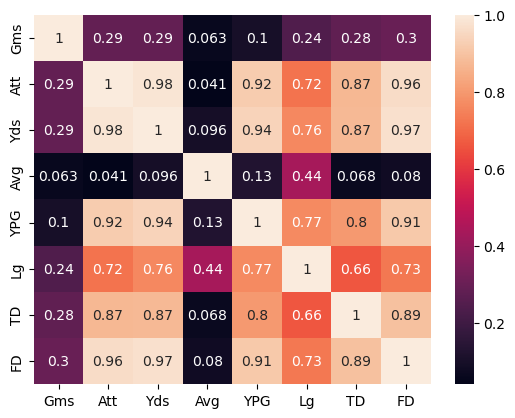

In [36]:
sns.heatmap(dfRush.corr(), annot=True)

In [ ]:
sns.heatmap(dfReceive.corr(), annot=True)